In [1]:
from google.colab import files
files.upload()  # This will prompt you to upload your kaggle.json file.

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"himanshurana0627","key":"579fc8e2cd9e9f000888e1d0fe5025f5"}'}

In [2]:
!mkdir -p ~/.kaggle  # Create the Kaggle directory
!cp kaggle.json ~/.kaggle/  # Copy the kaggle.json file to the Kaggle directory
!chmod 600 ~/.kaggle/kaggle.json  # Change the permissions of the kaggle.json file
!kaggle datasets download -d robikscube/hourly-energy-consumption

Dataset URL: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption
License(s): CC0-1.0
100% 11.4M/11.4M [00:01<00:00, 17.2MB/s]
100% 11.4M/11.4M [00:01<00:00, 10.0MB/s]


In [3]:
!unzip /content/hourly-energy-consumption.zip

Archive:  /content/hourly-energy-consumption.zip
  inflating: AEP_hourly.csv          
  inflating: COMED_hourly.csv        
  inflating: DAYTON_hourly.csv       
  inflating: DEOK_hourly.csv         
  inflating: DOM_hourly.csv          
  inflating: DUQ_hourly.csv          
  inflating: EKPC_hourly.csv         
  inflating: FE_hourly.csv           
  inflating: NI_hourly.csv           
  inflating: PJME_hourly.csv         
  inflating: PJMW_hourly.csv         
  inflating: PJM_Load_hourly.csv     
  inflating: est_hourly.paruqet      
  inflating: pjm_hourly_est.csv      


In [4]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
import os
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

In [5]:
data = pd.read_csv('/content/PJME_hourly.csv')

In [6]:
data.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [7]:
files_in_directory = os.listdir('/content')
print("Files in content directory:", files_in_directory)

for file in files_in_directory:
    if file.endswith('.csv') and file != 'PJME_hourly.csv':
        file_path = os.path.join('/content', file)
        os.remove(file_path)
        print(f"Removed: {file_path}")

remaining_files = os.listdir('/content')
print("Remaining files in content directory:", remaining_files)

Files in content directory: ['.config', 'DOM_hourly.csv', 'est_hourly.paruqet', 'COMED_hourly.csv', 'pjm_hourly_est.csv', 'PJMW_hourly.csv', 'AEP_hourly.csv', 'EKPC_hourly.csv', 'FE_hourly.csv', 'hourly-energy-consumption.zip', 'kaggle.json', 'DUQ_hourly.csv', 'PJM_Load_hourly.csv', 'DEOK_hourly.csv', 'DAYTON_hourly.csv', 'NI_hourly.csv', 'PJME_hourly.csv', 'sample_data']
Removed: /content/DOM_hourly.csv
Removed: /content/COMED_hourly.csv
Removed: /content/pjm_hourly_est.csv
Removed: /content/PJMW_hourly.csv
Removed: /content/AEP_hourly.csv
Removed: /content/EKPC_hourly.csv
Removed: /content/FE_hourly.csv
Removed: /content/DUQ_hourly.csv
Removed: /content/PJM_Load_hourly.csv
Removed: /content/DEOK_hourly.csv
Removed: /content/DAYTON_hourly.csv
Removed: /content/NI_hourly.csv
Remaining files in content directory: ['.config', 'est_hourly.paruqet', 'hourly-energy-consumption.zip', 'kaggle.json', 'PJME_hourly.csv', 'sample_data']


In [8]:
data = data.set_index('Datetime')

In [9]:
data.head(5)

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [10]:
data.index = pd.to_datetime(data.index)

In [11]:
plt.style.use('ggplot')

<Axes: title={'center': 'Plotting'}, xlabel='Datetime'>

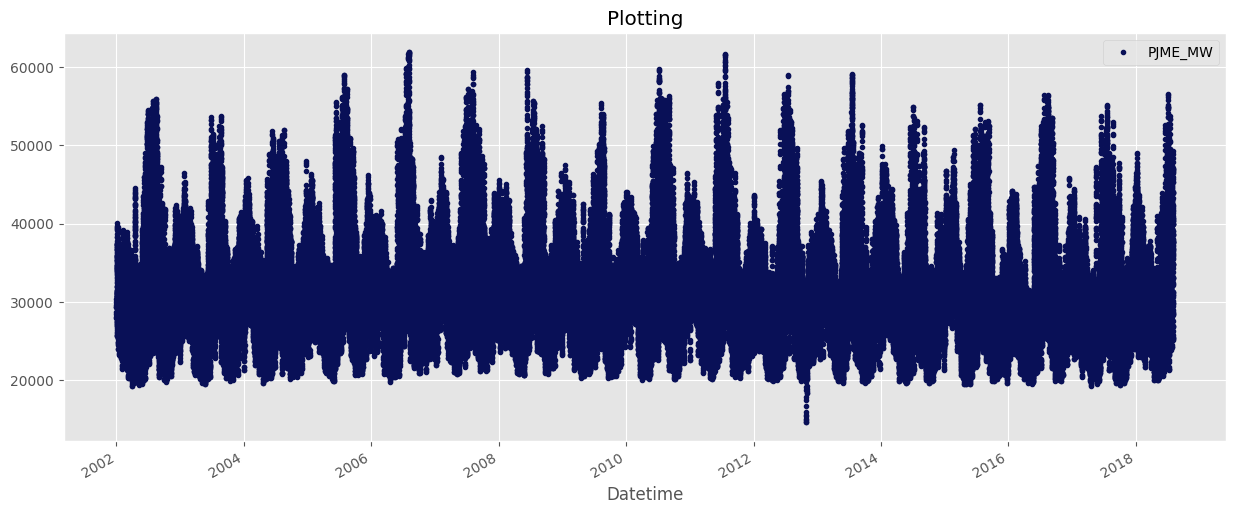

In [12]:
data.plot(style = '.', figsize = (15,6),title = 'Plotting', color = '#091057')

In [13]:
def filter_and_plot_daily_data(data, date_str):
    """
    Filters the DataFrame for a specific day (excluding 00:00) and plots the hourly energy consumption.

    Parameters:
    - data: pd.DataFrame: The input DataFrame containing datetime as the index and PJME_MW as the consumption data.
    - date_str: str: The date to filter in 'YYYY-MM-DD' format.

    Returns:
    - pd.DataFrame: Filtered DataFrame for the specified day, excluding 00:00.
    """
    # Ensure the index is in datetime format
    if not pd.api.types.is_datetime64_any_dtype(data.index):
        raise ValueError("The DataFrame index must be a datetime type.")
    plt.style.use('ggplot')
    # Define the start and end of the day
    start_date = f"{date_str} 00:00:00"
    end_date = f"{date_str} 23:59:59"

    # Filter the DataFrame for the specific day
    filtered_data = data[(data.index >= start_date) & (data.index <= end_date)]

    # Remove the 0 hour (00:00)
    filtered_data = filtered_data[filtered_data.index.hour != 0]

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_data.index, filtered_data['PJME_MW'], marker='o', color='b')
    plt.title(f"Hourly Energy Consumption on {date_str}")
    plt.xlabel("Time (Hour)")
    plt.ylabel("Energy Consumption (MW)")
    plt.axvline(pd.to_datetime(f"{date_str} 17:00:00"), color='r', linestyle='--')
    # Setting x-ticks for every hour (1 to 24)
    plt.xticks(ticks=filtered_data.index, labels=[hour.strftime('%H') for hour in filtered_data.index])
    plt.tight_layout()
    plt.show()

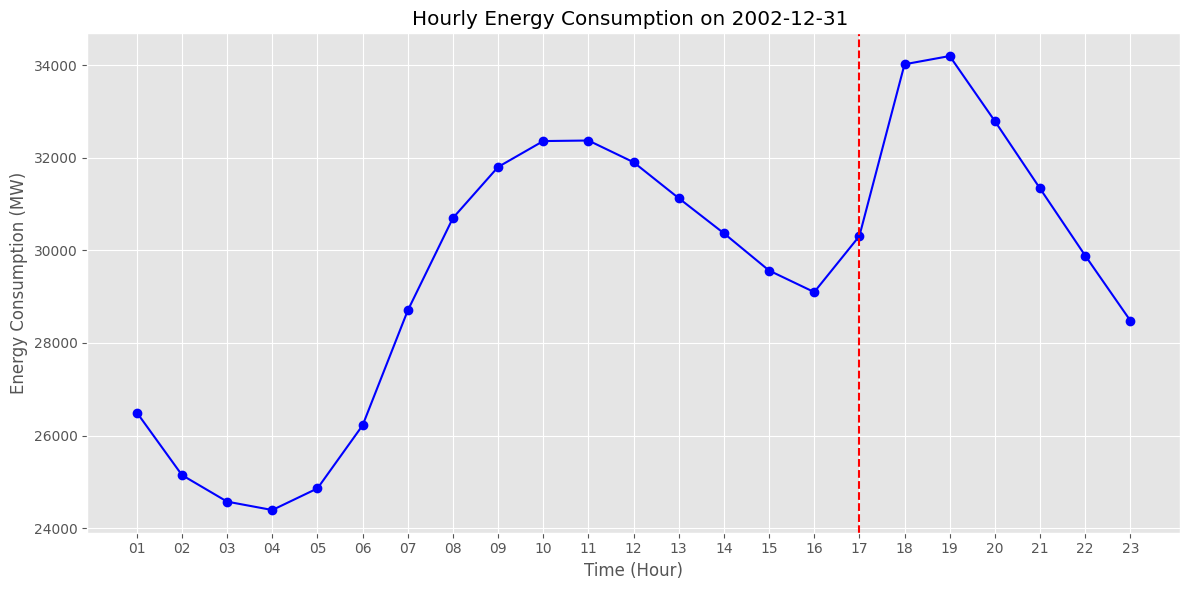

In [14]:
filter_and_plot_daily_data(data, '2002-12-31 ')

In [15]:

def filter_and_plot_weekly_data(data, start_date_str):
    """
    Filters the DataFrame for a specific week (7 days) and plots the hourly energy consumption for each day
    on separate plots.

    Parameters:
    - data: pd.DataFrame: The input DataFrame containing datetime as the index and PJME_MW as the consumption data.
    - start_date_str: str: The start date for the week in 'YYYY-MM-DD' format.

    Returns:
    - pd.DataFrame: Filtered DataFrame for the specified week.
    """
    # Ensure the index is in datetime format
    if not pd.api.types.is_datetime64_any_dtype(data.index):
        raise ValueError("The DataFrame index must be a datetime type.")

    plt.style.use('ggplot')  # Set the plotting style

    # Define the start and end of the week
    start_date = pd.to_datetime(start_date_str)
    end_date = start_date + pd.DateOffset(days=7)  # 7 days including start

    # Filter the DataFrame for the specific week
    filtered_data = data[(data.index >= start_date) & (data.index <= end_date)]

    # Create a new figure with specified size and layout
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(24, 12))
    fig.suptitle(f"Hourly Energy Consumption from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}", fontsize=16)

    # Initialize a counter for subplots
    day_count = 0

    # Loop through each day and plot separately
    for i in range(7):
        day_date = start_date + pd.DateOffset(days=i)
        day_data = filtered_data[filtered_data.index.date == day_date.date()]

        # Remove the 00:00 hour from day_data
        day_data = day_data[day_data.index.hour != 0]
        # Plotting only if data is available for that day
        if not day_data.empty:
            # Determine the row and column for the plot
            row = day_count // 4
            col = day_count % 4

            # Plotting on the respective axis
            axes[row, col].plot(day_data.index, day_data['PJME_MW'], marker='o', color='b')
            axes[row, col].set_title(day_date.strftime('%A, %Y-%m-%d'))
            axes[row, col].set_ylabel("Energy Consumption (MW)")
            axes[row, col].axvline(pd.to_datetime(f"{day_date.date()} 17:00:00"), color='r', linestyle='--', label='17:00')
            axes[row, col].legend()

            # Setting x-ticks for every hour
            axes[row, col].set_xticks(day_data.index)
            axes[row, col].set_xticklabels([hour.strftime('%H') for hour in day_data.index])
            axes[row, col].set_xlabel("Time (Hour)")

            day_count += 1  # Increment day counter

    # Hide any empty subplots
    for j in range(day_count, 8):
        axes[j // 4, j % 4].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout
    plt.show()

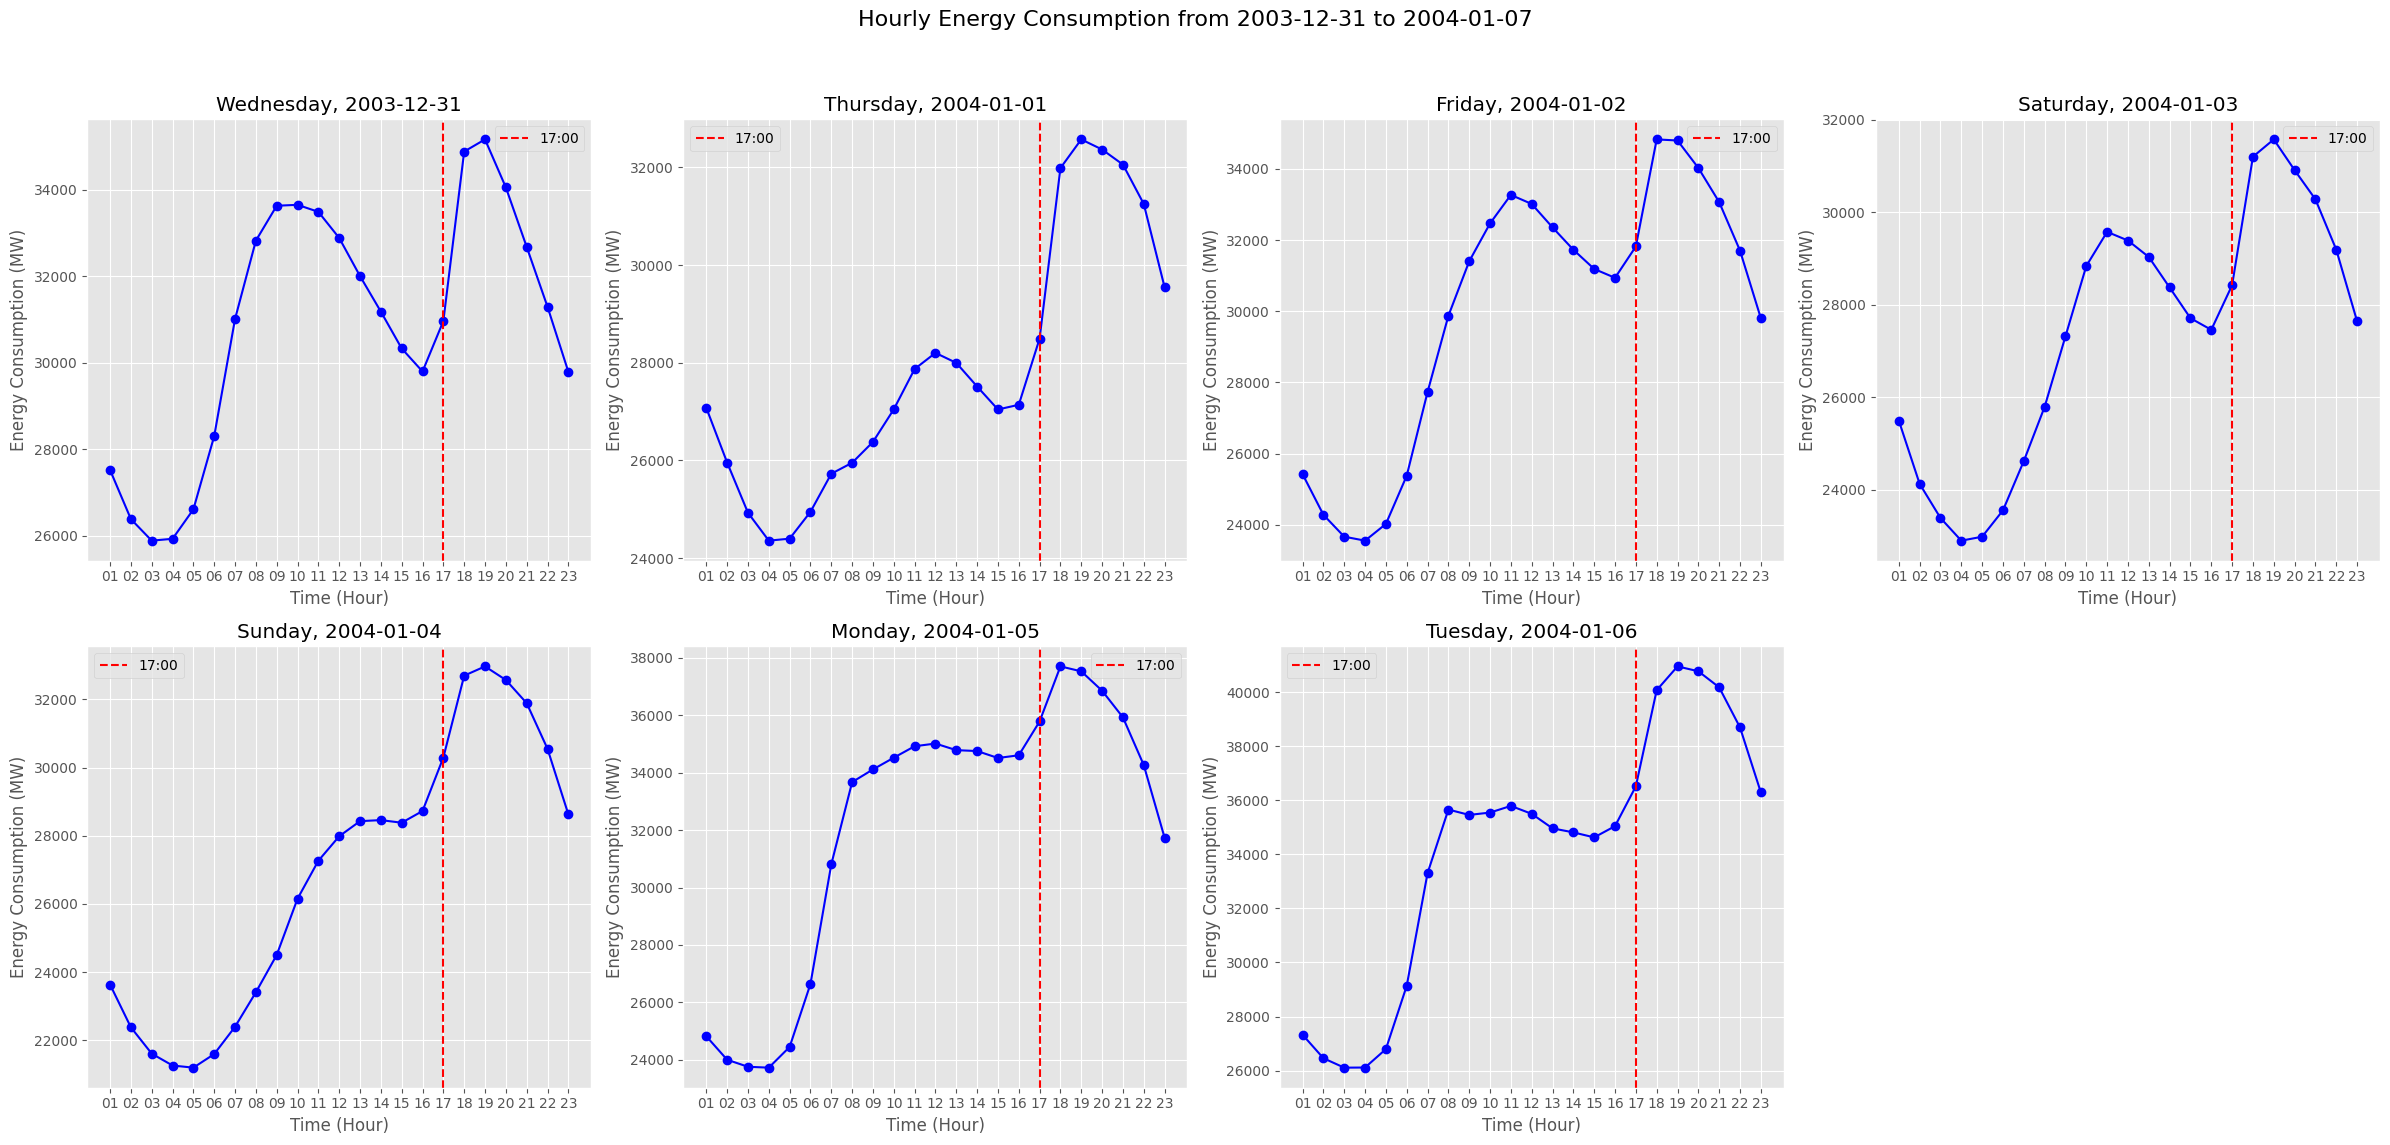

In [16]:
filter_and_plot_weekly_data(data, '2003-12-31')

Text(0, 0.5, 'Frequency')

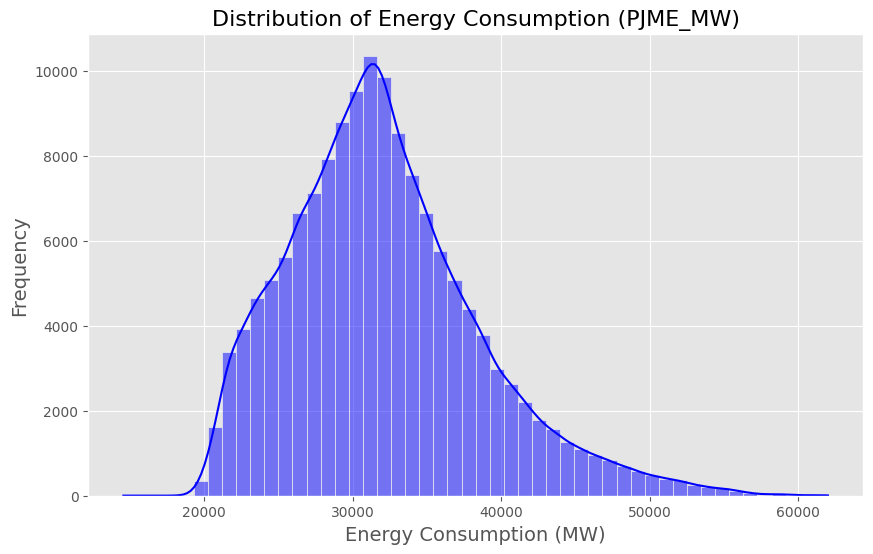

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(data['PJME_MW'].dropna(), bins=50, kde=True, color='blue')
plt.title('Distribution of Energy Consumption (PJME_MW)', fontsize=16)
plt.xlabel('Energy Consumption (MW)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

In [18]:
index = (145366 // 100) * 70
specific_row = data.iloc[index]
print(specific_row)

PJME_MW    25210.0
Name: 2013-05-25 23:00:00, dtype: float64


In [19]:
train = data.loc[data.index < '2013-05-25']
test = data.loc[data.index >= '2013-05-25']

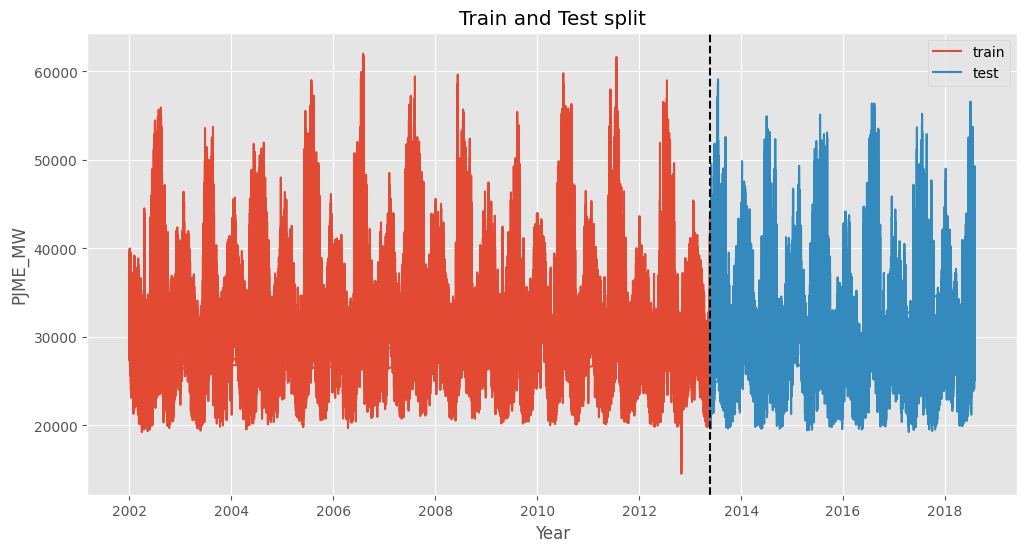

In [20]:
plt.figure(figsize = (12,6))
plt.plot(train, label = 'train')
plt.plot(test, label = 'test')
plt.title('Train and Test split')
plt.xlabel('Year')
plt.ylabel('PJME_MW')
plt.axvline(pd.to_datetime('2013-05-25'), color='black', linestyle='--')
plt.legend()

In [21]:
def oneweekofdata(data, date1, date2):
    df = data.loc[(data.index > date1) & (data.index < date2)]
    return df

<Axes: xlabel='Datetime'>

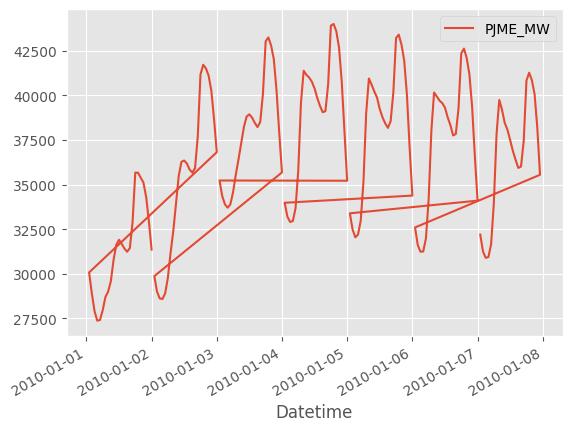

In [22]:
oneweekofdata(data, '2010-01-01', '2010-01-08').plot()

Feature Creation

In [23]:
def create_feature(data):
    '''
    Create the feature in the data
    '''
    data = data.copy()
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['quarter'] = data.index.quarter
    data['month'] = data.index.month
    data['year'] = data.index.year
    data['dayofyear'] = data.index.dayofyear
    return data

In [24]:
data = create_feature(data)

Visualize Feature

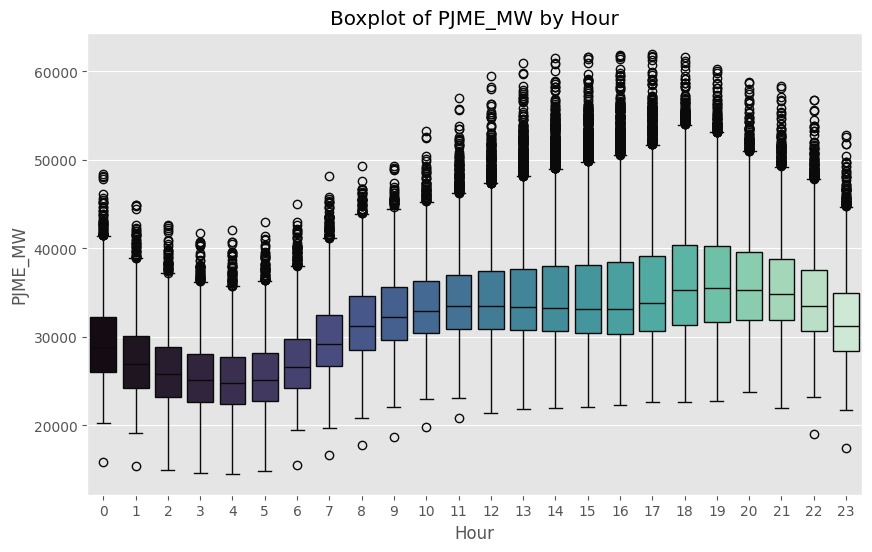

In [25]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='hour', y='PJME_MW', palette='mako')  # You can change 'pastel' to any other palette
plt.title('Boxplot of PJME_MW by Hour')
plt.xlabel('Hour')
plt.ylabel('PJME_MW')
plt.show()

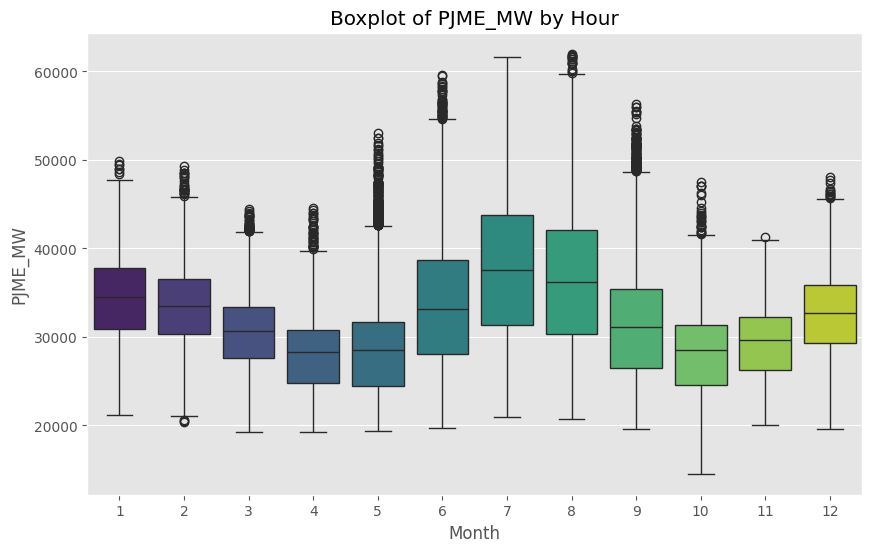

In [26]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='month', y='PJME_MW', palette='viridis')
plt.title('Boxplot of PJME_MW by Hour')
plt.xlabel('Month')
plt.ylabel('PJME_MW')
plt.show()

In [27]:
data.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [28]:
feature = ['hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear']
target = ['PJME_MW']

In [29]:
train = create_feature(train)
test = create_feature(test)

In [30]:
X_train = train[feature]
y_train = train[target]
X_test = test[feature]
y_test = test[target]

In [41]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate = 0.001)
reg.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],  # Pass eval_set here
        verbose=50)

[0]	validation_0-rmse:6512.85318
[50]	validation_0-rmse:6307.51515
[100]	validation_0-rmse:6116.26120
[150]	validation_0-rmse:5938.32179
[200]	validation_0-rmse:5772.32333
[250]	validation_0-rmse:5618.82969
[300]	validation_0-rmse:5477.56955
[350]	validation_0-rmse:5344.91364
[400]	validation_0-rmse:5221.22747
[450]	validation_0-rmse:5106.97258
[500]	validation_0-rmse:5000.30994
[550]	validation_0-rmse:4901.80818
[600]	validation_0-rmse:4809.93403
[650]	validation_0-rmse:4725.64440
[700]	validation_0-rmse:4648.47968
[750]	validation_0-rmse:4578.19098
[800]	validation_0-rmse:4512.80802
[850]	validation_0-rmse:4452.07974
[900]	validation_0-rmse:4396.11417
[950]	validation_0-rmse:4345.38929
[999]	validation_0-rmse:4299.92173


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

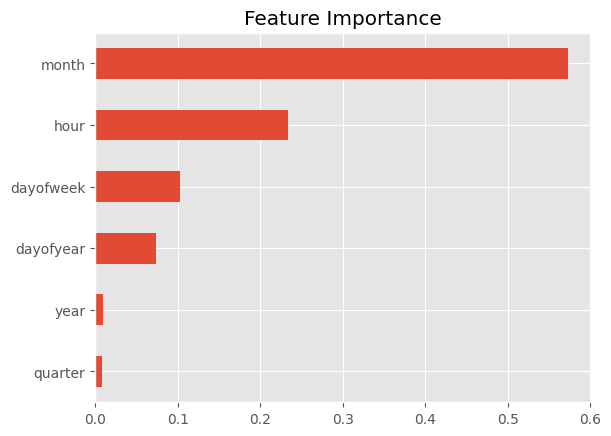

In [53]:
fi = pd.DataFrame(data = reg.feature_importances_ ,
             index = reg.feature_names_in_,
             columns = ['importance'])
fi.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance',legend = False)
plt.show()

Forecast on Dataset


In [54]:
test['predict'] = reg.predict(X_test)

In [56]:
df = data.merge(test['predict'], how ='left', left_index = True, right_index = True)

<Axes: title={'center': 'Plotting'}, xlabel='Datetime'>

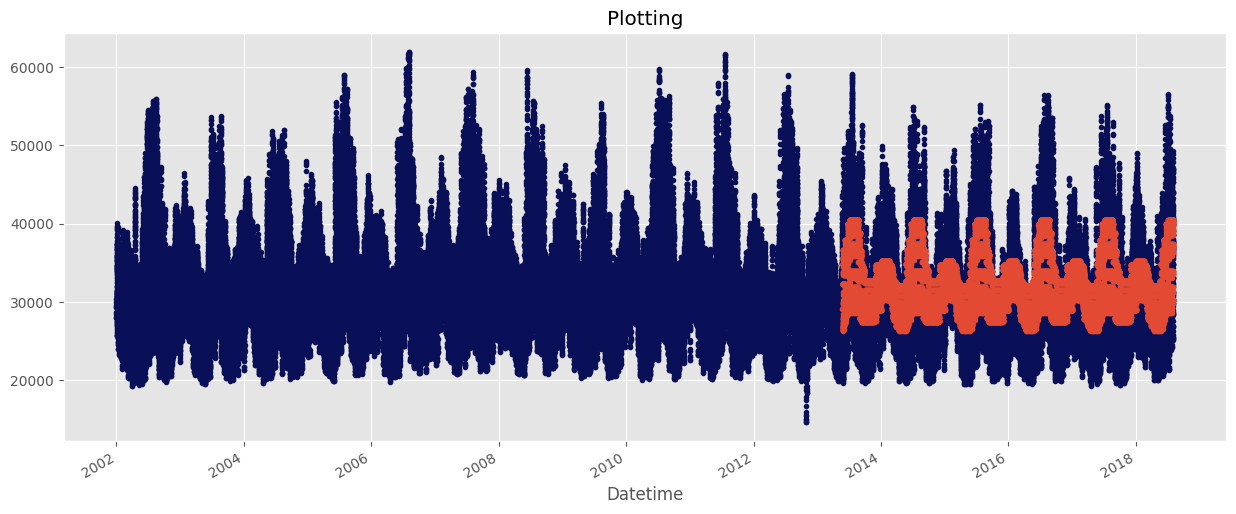

In [62]:
ax = data.PJME_MW.plot(style = '.', figsize = (15,6),title = 'Plotting', color = '#091057')
df['predict'].plot(ax = ax, style = '.')

In [64]:
score = np.sqrt(mean_squared_error(test.PJME_MW, test.predict))
print(f"Score for the mean squared is {score}")

Score for the mean squared is 4299.921727112814
